In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import random as random 
import math
df_train = pd.read_csv("train.csv")
np.random.seed(123)
n = len(df_train)

yes = df_train[df_train.Loan_Status=="Y"]
no = df_train[df_train.Loan_Status=="N"]
n_yes = df_train[df_train.Loan_Status=="Y"].shape[0]
n_no = df_train[df_train.Loan_Status=="N"].shape[0]

age_yes = np.concatenate( [np.random.randint(32,58,int(n_yes*0.7)),np.random.randint(18,29,int((n_yes*0.3)+1))])
age_no = np.concatenate( [np.random.randint(32,58,int(n_no*0.2)),np.random.randint(61,85,int(n_no*0.3)),np.random.randint(18,29,int((n_no*0.5)+1))])


mask_yes = df_train.Loan_Status == "Y"
mask_no  = df_train.Loan_Status == "N"

df_train.loc[mask_yes, "age"] = age_yes
df_train.loc[mask_no,  "age"] = age_no


df = df_train.copy()


def drop_id(df):
    if not df["Loan_ID"].is_unique:
        print("Duplicates detected. Removing...")
        df = df.drop_duplicates(subset="Loan_ID")
    else:
        print("No duplicates on Loan_ID and we droped this column")
    df = df.drop("Loan_ID", axis=1)
    return df

df = drop_id(df)

No duplicates on Loan_ID and we droped this column


## 3. EDA



## Data Visualization

Visualization of the target variable

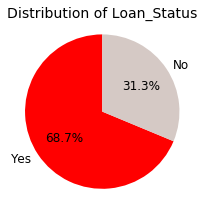

In [2]:
plt.figure(figsize=(3, 3))
plt.pie(df['Loan_Status'].value_counts(), 
        labels=["Yes", "No"], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors = ['red', '#d5c9c5'],
        textprops={'fontsize': 12})

plt.title("Distribution of Loan_Status", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

Barplot des données catégorielles (ou des données numériques avec moins de 5 catégories)

In [3]:
def barplots_columns(df, column_list):
    cols = [col for col in column_list if df[col].dtype == 'object' or df[col].nunique() < 15]

    n = len(cols)
    ncols = 4
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        df[col].value_counts().plot(kind='bar', color='red', edgecolor='black', linewidth=0.5, ax=ax)
        ax.set_title(f"Value distribution for '{col}'")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


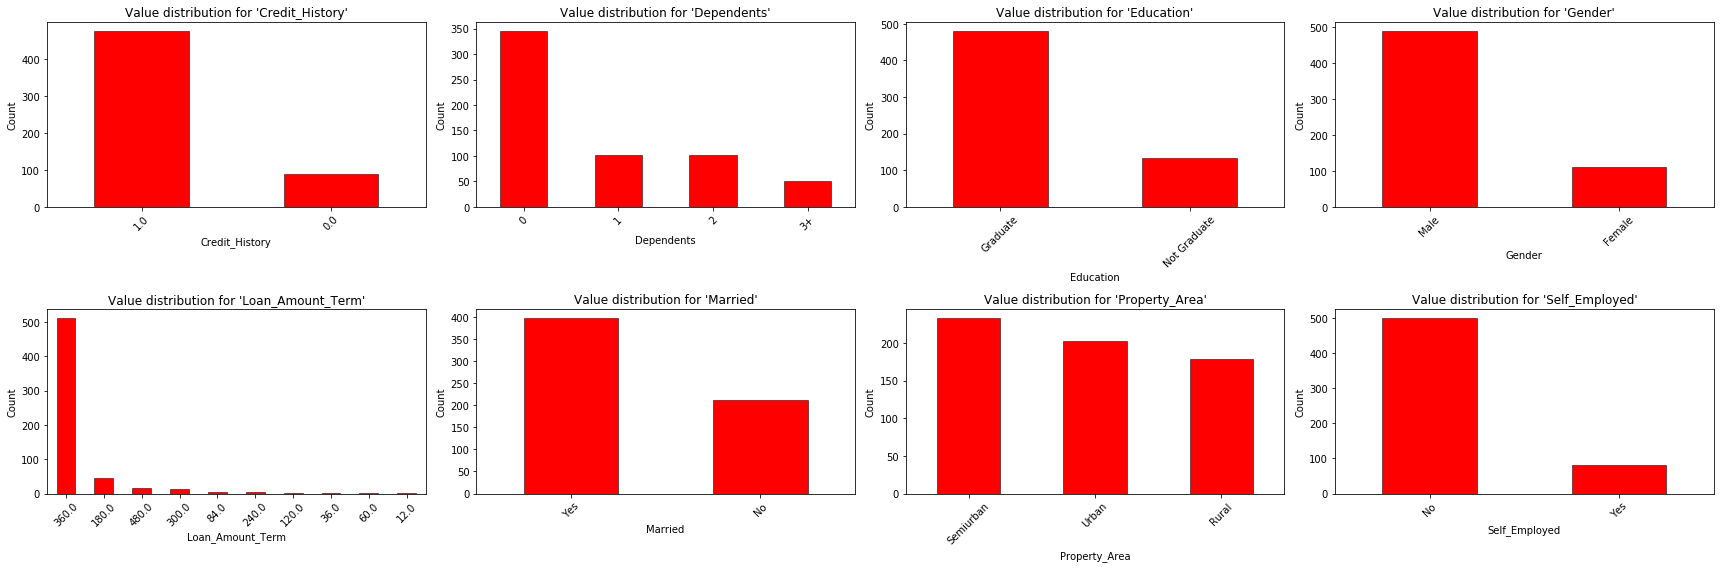

In [4]:
barplots_columns(df, df.columns.difference(["Loan_Status"]))

We can see that the dominant category is clearly prevalent in each categorical feature.

Plot continuous variable

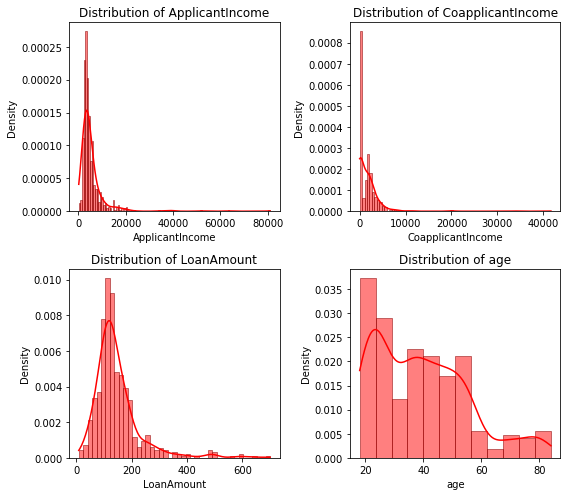

In [5]:

num_cols = [col for col in df.select_dtypes(include=np.number).columns if df[col].nunique(dropna=True) > 15]

n = len(num_cols)
if n == 0:
    raise ValueError("No numeric column with more than 15 unique values.")
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.histplot(df[col].dropna(), kde=True, color='red', edgecolor='darkred', linewidth=0.5, ax=ax, stat='density')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


# Relation Target / Variable


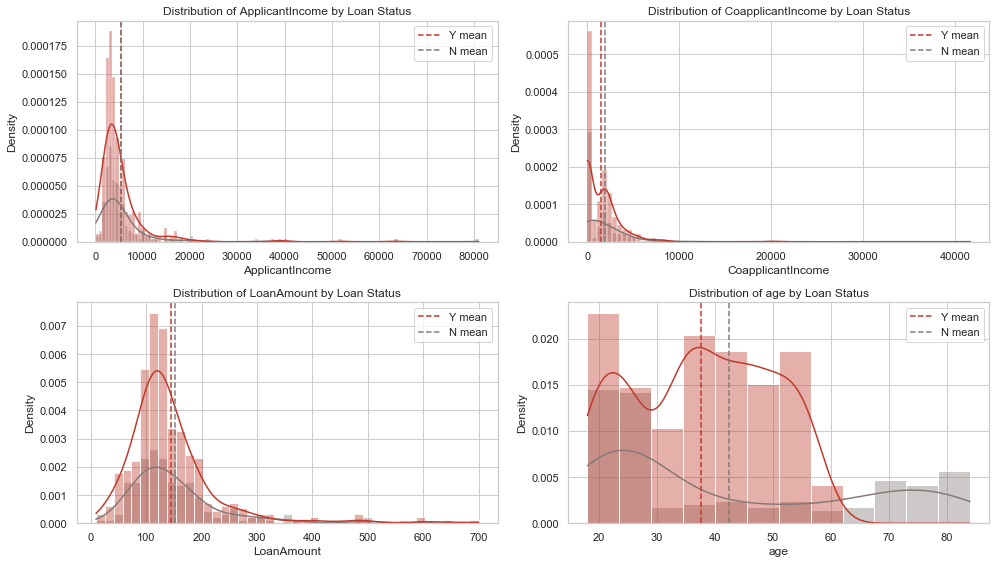

In [9]:

sns.set_theme(style="whitegrid")
palette = {"Y": "#c0392b" ,"N": "#867978"} 

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(["Loan_Amount_Term", "Credit_History"])

for start in range(0, len(num_cols), 4):
    chunk = list(num_cols[start:start+4])
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes = axes.flatten()

    for i, col in enumerate(chunk):
        ax = axes[i]
        
        sns.histplot(
            data=df,
            x=col,
            hue='Loan_Status',
            kde=True,
            stat='density',
            palette=palette,
            alpha=0.4,
            ax=ax
        )


        for status, color in palette.items():
            mean_val = df.loc[df['Loan_Status'] == status, col].mean()
            ax.axvline(mean_val, color=color, linestyle="--", lw=1.5,
                       label=f"{status} mean")

        ax.set_title(f'Distribution of {col} by Loan Status', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.legend(loc='best', frameon=True)


    for j in range(len(chunk), 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



In [7]:
print((df.loc[df["Loan_Status"] == "Y", "LoanAmount"]).var())
print((df.loc[df["Loan_Status"] == "N", "LoanAmount"]).var())

7307.617992997443
7372.417556783301


In [10]:
def stacked_target_by_categories_filtered(df, cols, target="Loan_Status", per_row=3):

    cols = [c for c in cols if c != target]
    if not cols:
        return

    color_map = {"Y": "#c0392b", "N": "#867978"}

    n = len(cols)
    ncols = per_row
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten()

    for ax, col in zip(axes, cols):

        sub = df[[col, target]].dropna(subset=[col, target])
        if sub.empty:
            ax.set_visible(False)
            continue


        ct = pd.crosstab(sub[col], sub[target], normalize="index")


        for status in ["Y", "N"]:
            if status not in ct.columns:
                ct[status] = 0.0
        ct = ct[["Y", "N"]]

        ct.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=[color_map["Y"], color_map["N"]],
            legend=False
        )

        ax.set_title(f"{target} proportion by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Proportion")
        ax.set_ylim(0, 1)
        ax.tick_params(axis="x", rotation=45)

    for extra_ax in axes[len(cols):]:
        extra_ax.set_visible(False)

    from matplotlib.patches import Patch
    legend_handles = [Patch(color=color_map["Y"], label="Y"), Patch(color=color_map["N"], label="N")]
    fig.legend(legend_handles, ["Y", "N"], title=target, loc="lower center", ncol=2, frameon=True)

    plt.tight_layout(rect=[0, 0.05, 1, 1]) 
    plt.show()



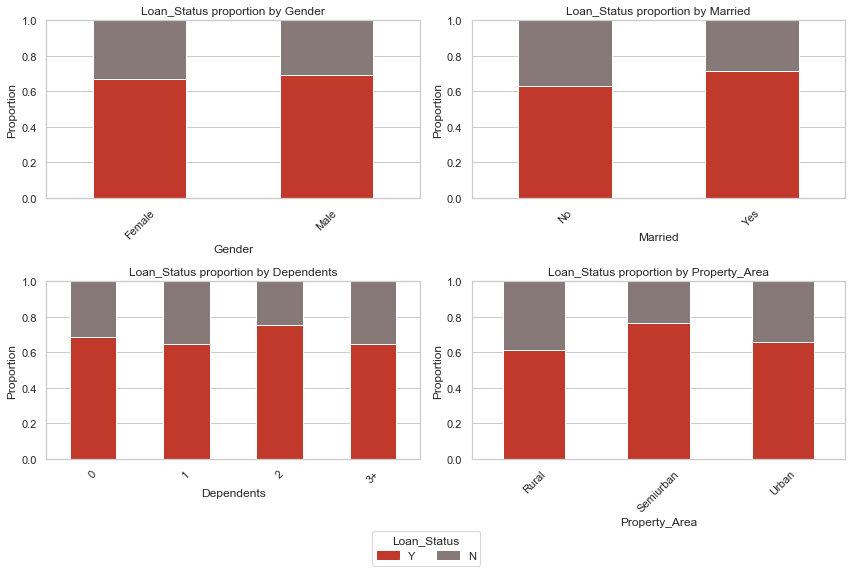

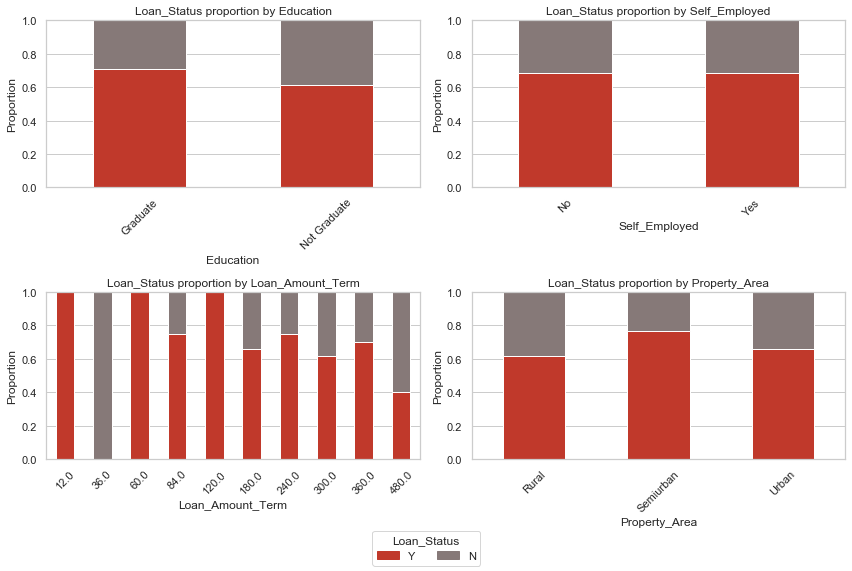

In [11]:
cols_1 = ["Gender", "Married", "Dependents", "Property_Area"]
cols_2 = ["Education", "Self_Employed", "Loan_Amount_Term", "Property_Area"]
stacked_target_by_categories_filtered(df, cols_1, target="Loan_Status", per_row=2)
stacked_target_by_categories_filtered(df, cols_2, target="Loan_Status", per_row=2)


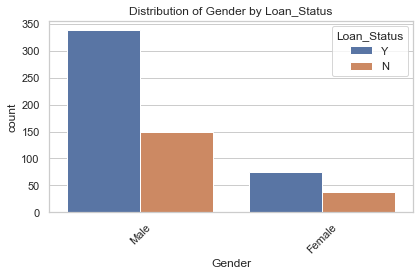

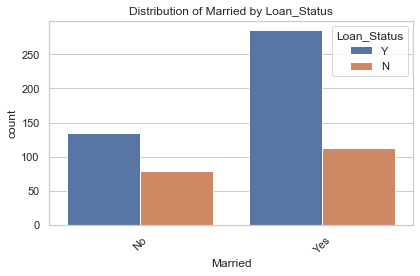

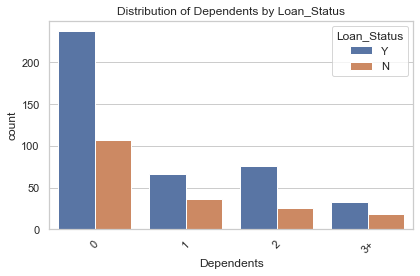

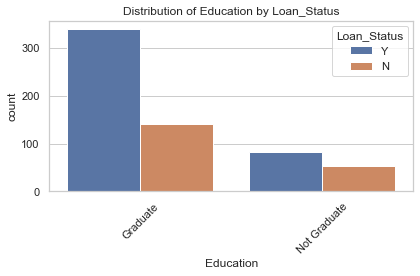

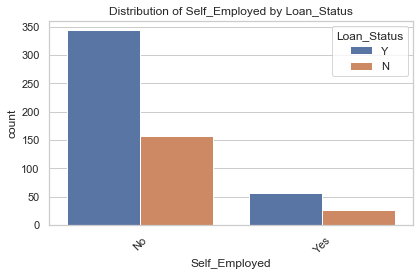

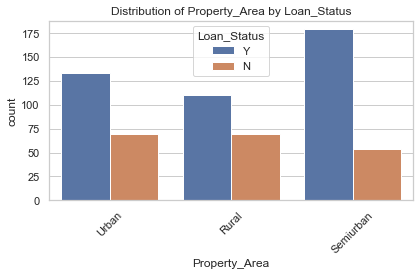

In [21]:
for col in df.select_dtypes(include='object').columns:
    if col == "Loan_Status":
        continue
    else:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue='Loan_Status')
        plt.title(f'Distribution of {col} by Loan_Status')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


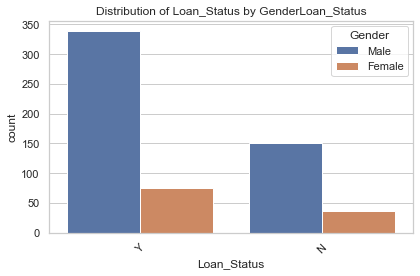

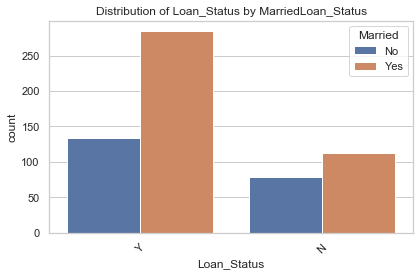

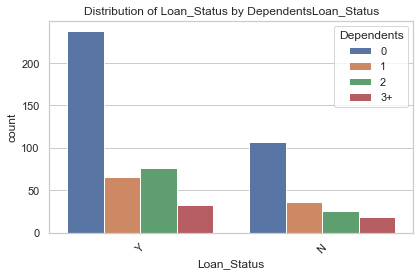

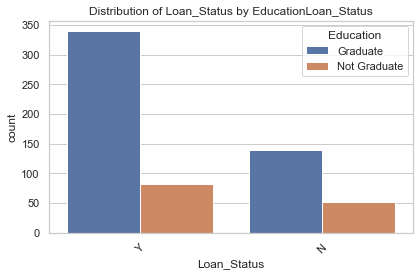

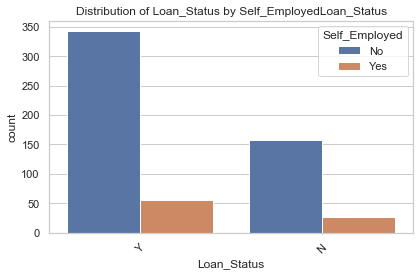

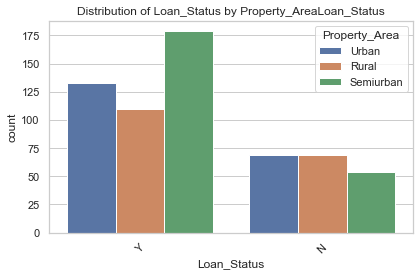

In [12]:
for col in df.select_dtypes(include='object').columns:
    if col == "Loan_Status":
        continue
    else:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x='Loan_Status', hue=col)
        plt.title(f'Distribution of Loan_Status by {col}Loan_Status')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [13]:
def pie_charts_by_category(df, target='Loan_Status'):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        if col == "Loan_Status":
            continue
        else:
            categories = df[col].unique()
            n = len(categories)
            n_cols = 2
            n_rows = (n + 1) // 2

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))
            axes = axes.flatten()

            for i, category in enumerate(categories):
                subset = df[df[col] == category]
                counts = subset[target].value_counts(normalize=True) * 100
                labels = counts.index
                sizes = counts.values
                colors = ['#e74c3c', '#c0392b']  

                wedges, texts, autotexts = axes[i].pie(
                    sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'color': "white"}
                )
                axes[i].set_title(f"{col} = {category}", fontsize=12)
                axes[i].axis('equal')


            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])

            plt.suptitle(f"Répartition de '{target}' pour chaque modalité de '{col}'", fontsize=16)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()


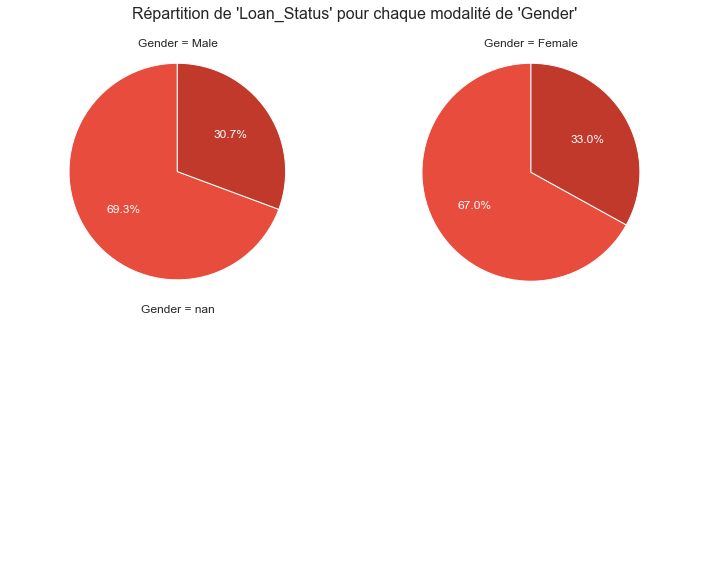

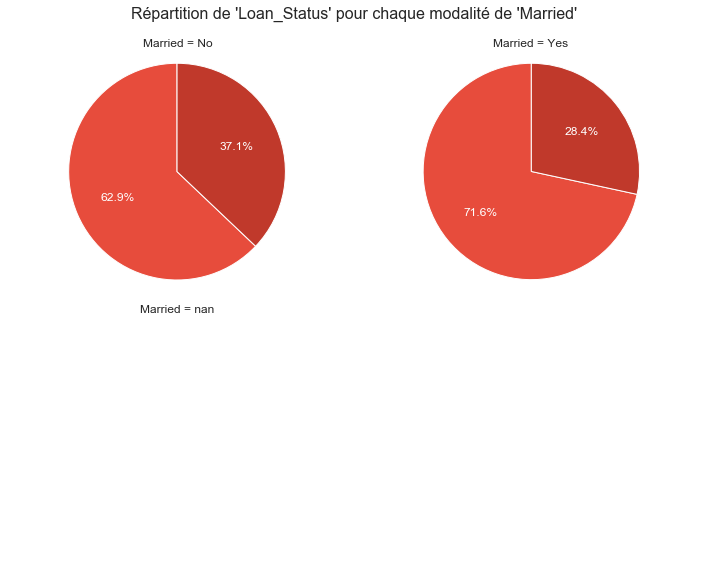

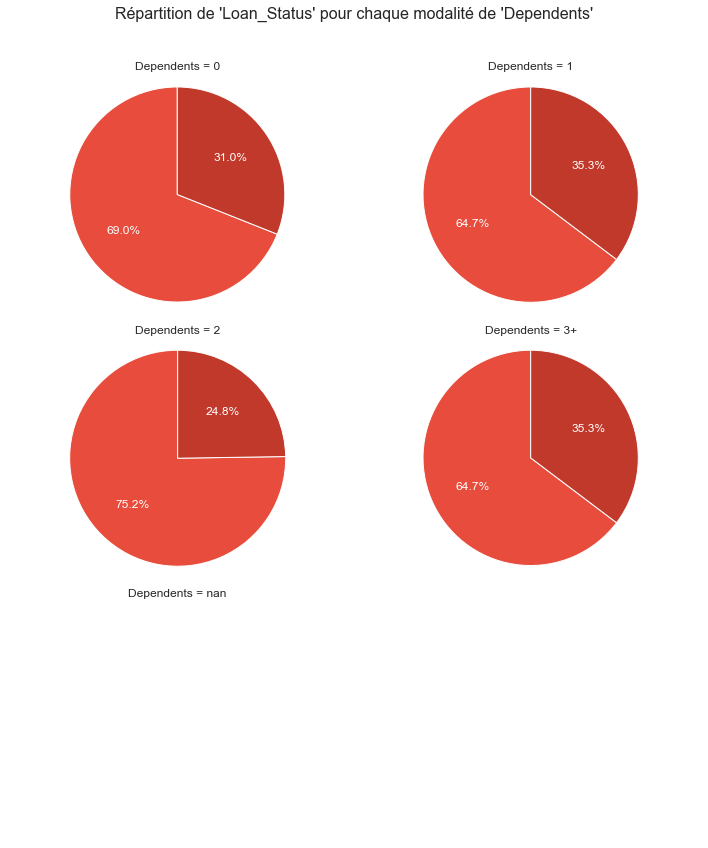

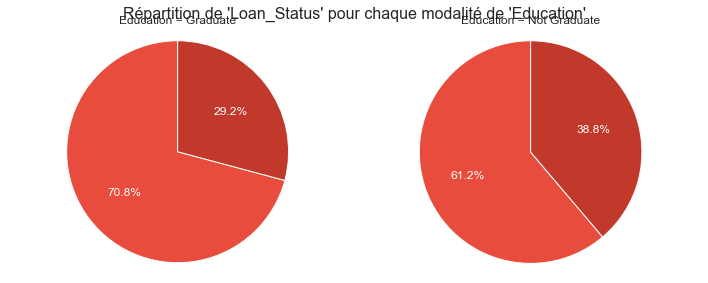

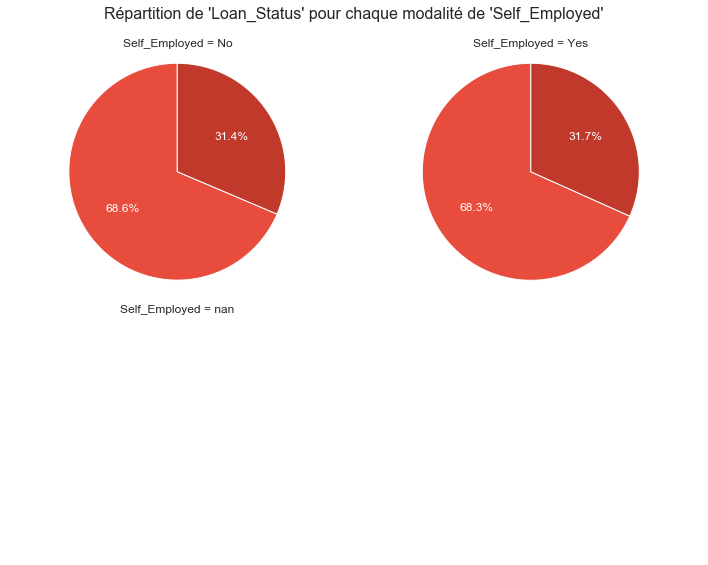

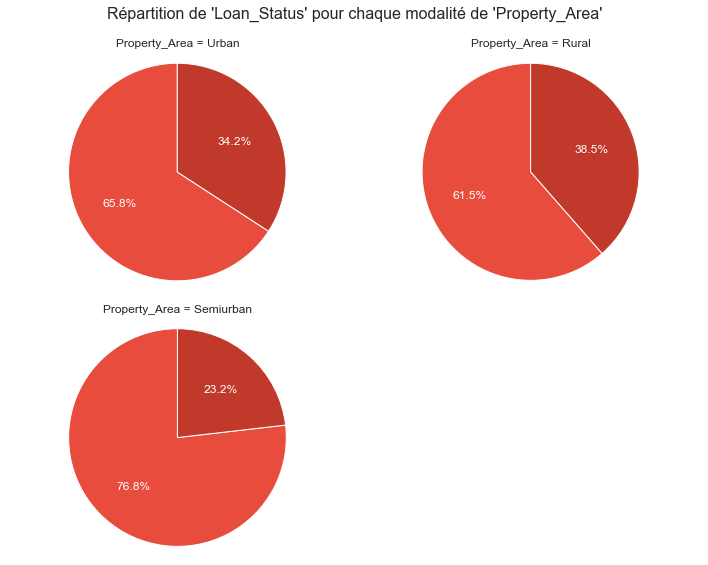

In [14]:
pie_charts_by_category(df)


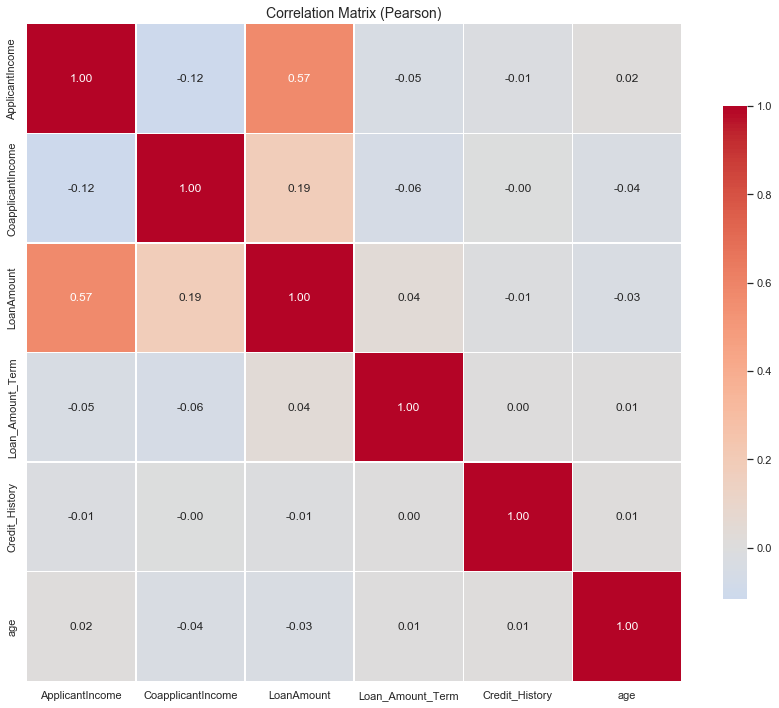

In [15]:

numeric = df.select_dtypes(include=['float64', 'int64'])


corr = numeric.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,          
    fmt=".2f",           
    cmap="coolwarm",     
    center=0,           
    square=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
)
plt.title("Correlation Matrix (Pearson)", fontsize=14)
plt.tight_layout()
plt.show()
